# Discussion: Anti-aliasing Effect 


According to the paper "On Buggy Resizing Libraries and Surprising Subtleties in FID Calculation" by @Richard Zhang, the selection of image resizing library and kernel matter to the Fréchet Inception (FID) score consistency because of the aliasing effect. (See: https://www.cs.cmu.edu/~clean-fid/)

Thus, we recommend to use anti-aliasing from beacon_aug.

In [2]:
import beacon_aug as BA
BA.properties.isAntiAliasing(BA.Resize, library= "torchvision",interpolation = "linear" )

InterpolationMode.BILINEAR


True

## 1. Discussion on "resize" operator

Whether or not the operator is anti-aliasing  depends on the PSNR of original and rescaled image
As example showing below, only PSNR of operator-interpolation combinations > 18dB are anti-aliasing.


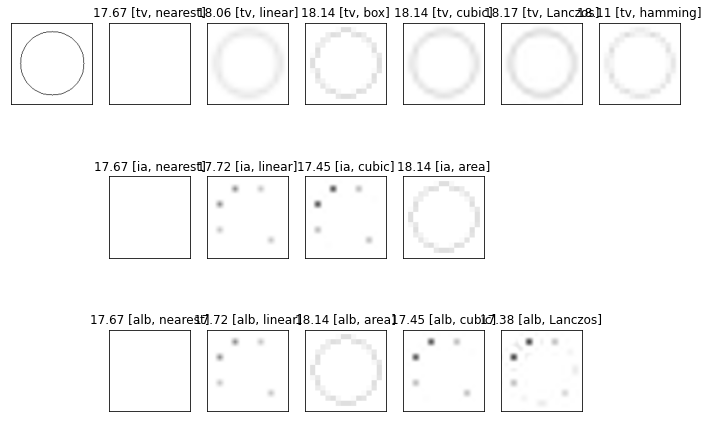

In [1]:
import cv2
import torchvision.transforms.functional as torch_f
import matplotlib.pyplot as plt
import numpy as np
import beacon_aug as BA


library = 'torchvision'
interpolation='linear'

def psnr_uint8(img0, img1):
	return -10*np.log10(np.mean((img0/255. - img1/255.)**2))

def resize_psnr(library='torchvision', interpolation='linear'):
	img_np = np.zeros((128, 128, 3), dtype='uint8')+255
	img_np = cv2.circle(img_np, (128//2, 128//2), 50, (0, 0, 0), 1)

	# interpolation_all = ["nearest", "linear", "area", "cubic", "Lanczos", "hamming"]
	interpolation_dict = {"albumentations":
			{"nearest": cv2.INTER_NEAREST,
			"linear": cv2.INTER_LINEAR,
			"area": cv2.INTER_AREA,
			"cubic": cv2.INTER_CUBIC,
			"Lanczos": cv2.INTER_LANCZOS4,
			},
		"imgaug":
			{"nearest": "nearest",
			"linear": "linear",
			"cubic": "cubic",
			"area": "area"
			},
		"torchvision":
			{"nearest": torch_f.InterpolationMode.NEAREST,
			"linear": torch_f.InterpolationMode.BILINEAR,
			"box": torch_f.InterpolationMode.BOX,
			"cubic": torch_f.InterpolationMode.BICUBIC,
			"Lanczos": torch_f.InterpolationMode.LANCZOS,
			"hamming": torch_f.InterpolationMode.HAMMING,
			}}
	interp = interpolation_dict[library][interpolation] if library in interpolation_dict else interpolation
	# print(interp)

	op = BA.Resize(p=1, library=library, interpolation=interp, height=16, width=16)
	op_up = BA.Resize(p=1, library=library, interpolation=interp, height=128, width=128)

	img_resized = op(image=img_np)["image"].copy()
	img_up = op_up(image=img_resized)["image"].copy()

	return psnr_uint8(img_np, img_up), img_up


img_np = np.zeros((128, 128, 3), dtype='uint8')+255
img_np = cv2.circle(img_np, (128//2, 128//2), 50, (0, 0, 0), 1)

plt.figure(figsize=(12,8))
plt.subplot(3,7,1)
plt.imshow(img_np)
plt.xticks([])
plt.yticks([])

for (ii,interp) in enumerate(['nearest', 'linear', 'box', 'cubic', 'Lanczos', 'hamming']):
	plt.subplot(3,7,1+ii+1)
	psnr, img_up = resize_psnr(library='torchvision', interpolation=interp)
	plt.imshow(img_up)
	plt.xticks([])
	plt.yticks([])
	plt.title('%.2f [tv, %s]'%(psnr, interp))

for (ii,interp) in enumerate(['nearest', 'linear', 'cubic', 'area']):
	plt.subplot(3,7,8+ii+1)
	psnr, img_up = resize_psnr(library='imgaug', interpolation=interp)
	plt.imshow(img_up)
	plt.xticks([])
	plt.yticks([])
	plt.title('%.2f [ia, %s]'%(psnr, interp))

for (ii,interp) in enumerate(['nearest', 'linear', 'area', 'cubic', 'Lanczos']):
	plt.subplot(3,7,15+ii+1)
	psnr, img_up = resize_psnr(library='albumentations', interpolation=interp)
	plt.imshow(img_up)
	plt.xticks([])
	plt.yticks([])
	plt.title('%.2f [alb, %s]'%(psnr, interp))

plt.show()


## 2. Discussion on "affine transform" operator


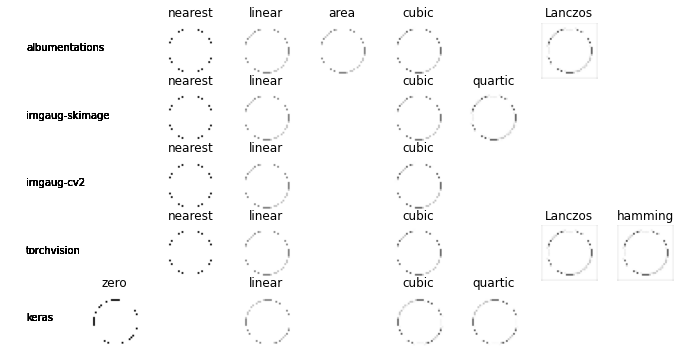

In [3]:

interpolation_dict = {"albumentations":
                      {"nearest": cv2.INTER_NEAREST,
                       "linear": cv2.INTER_LINEAR,
                       "area": cv2.INTER_AREA,
                       "cubic": cv2.INTER_CUBIC,
                       "Lanczos": cv2.INTER_LANCZOS4,
                       },
                      "imgaug-skimage":
                            {"nearest": 0,
                            "linear": 1,
                            "cubic": 3,
                            "quartic": 4,
                            "quintic":5.
                            },
                       "imgaug-cv2":
                            {"nearest": 0,
                            "linear": 1,
                            "cubic": 3,
                            },
                      "torchvision":
                        {"nearest": torch_f.InterpolationMode.NEAREST,
                        "linear": torch_f.InterpolationMode.BILINEAR,
                        "box": torch_f.InterpolationMode.BOX,
                        "cubic": torch_f.InterpolationMode.BICUBIC,
                        "Lanczos": torch_f.InterpolationMode.LANCZOS,
                        "hamming": torch_f.InterpolationMode.HAMMING,
                        },
                      "keras":  
                        {"zero": 0,
                        "linear": 1,
                        "quartic": 2,
                        "cubic": 3,
                        }
                       }
interpolation_all = ["zero","nearest", "linear", "area","cubic","quartic", "Lanczos","hamming"]


f, ax = plt.subplots(len(interpolation_dict), len(interpolation_all)+1, figsize=(12,6))
for i_k, kernel in enumerate( interpolation_all):
    for i_l, library in enumerate(interpolation_dict):
        ax[i_l][0].text(0.3, 0.5, library)
        ax[i_l][0].axis("off")
        if kernel in interpolation_dict[library]:
            interp= interpolation_dict[library][kernel]
            
            if library == "albumentations":
                aug = BA.Affine(p=1,library=library, scale=0.25, interpolation= interp)
            elif library == "imgaug-cv2" : #library == "imgaug" or "torchvision"
                aug = BA.Affine(p=1,library="imgaug", scale = 0.25, order = interp,backend="cv2")
            elif library == "imgaug-skimage" : #library == "imgaug" or "torchvision"
                aug = BA.Affine(p=1,library="imgaug", scale = 0.25, order = interp,backend="skimage")
            elif library == "torch":
                aug = BA.Affine(p=1,library=library, scale= (0.25, 0.25), interpolation= interp)
            elif library == "keras":
                aug = BA.Affine(p=1,library=library, zx=4,zy=4, order=interp)     

            img_resized = aug(image=img_np)["image"].copy()
            ax[i_l, i_k+1].imshow(img_resized[48:48+32,48:48+32 ])
            ax[i_l, i_k+1].set_title(kernel )
        ax[i_l,i_k+1].axis('off')
        
plt.show()